<a href="https://colab.research.google.com/github/kamiliaps/PRJ-KamiliaAriffianti/blob/main/DeepLabV3Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Imports, Reproducibility, Dataset (LMDB + transforms)

In [1]:
# Mount the google drive (or import data from wherever necessary)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Install dependencies

In [2]:
pip install lmdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 18.5 MB/s eta 0:00:00


In [3]:
pip install torchsampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [4]:
# Imports and setup
import os, cv2, lmdb, pickle, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, Subset, Sampler, random_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
# Reproducibility
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
set_seed()

In [6]:
# 2. Dataset Class
class SurgicalLMDBDataset(Dataset):
  def __init__(self, lmdb_path):
    self.env = lmdb.open(lmdb_path, readonly=True, lock=False, readahead=False)
      with self.env.begin() as txn:
        self.keys = [key for key, _ in txn.cursor()]

  def __len__(self):
    return len(self.keys)

  def __getitem__(self, idx):
    with self.env.begin() as txn:
      data = pickle.loads(txn.get(self.keys[idx]))
      image = cv2.imdecode(np.frombuffer(data["image"], np.uint8), cv2.IMREAD_COLOR)
      mask = cv2.imdecode(np.frombuffer(data["mask"], np.uint8), cv2.IMREAD_GRAYSCALE)

      image = cv2.resize(image, (512, 512))
      mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    return image, mask

In [7]:
# Transform Wrapper
class TransformDataset(Dataset):
  def __init__(self, base_dataset, transform):
      self.base_dataset = base_dataset
      self.transform = transform

  def __len__(self):
      return len(self.base_dataset)

  def __getitem__(self, idx):
      image, mask = self.base_dataset[idx]

      # Apply augmentation
      augmented = self.transform(image=image, mask=mask)
      image, mask = augmented["image"], augmented["mask"]

      # Remap mask labels: 0 → 0, 29 → 1, 149 → 2
      remapped = torch.zeros_like(mask)
      remapped[mask == 29] = 1
      remapped[mask == 149] = 2

      return image, remapped.long()

# Part 2: Stratified Batch Sampler, Label/Weight Computation

In [8]:
# Image-level Label Generator for Stratified Sampling
def get_labels(dataset):
  labels = []
  for _, mask in dataset:
    mask = mask.flatten()
    counts = np.bincount(mask, minlength=150)
    dominant = max([0, 29, 149], key=lambda c: counts[c])
    labels.append(dominant)
  return labels

In [9]:
# Class Weights (for CrossEntropyLoss)
def compute_class_weights(dataset, original_ids=[0, 29, 149], new_ids=[0, 1, 2]):
  pixel_counts = {new: 0 for new in new_ids}

  for _, mask in dataset:
    mask = np.array(mask).flatten()
    for orig, new in zip(original_ids, new_ids):
      pixel_counts[new] += np.sum(mask == orig)

  total = sum(pixel_counts.values())

  # Calculate weights using remapped class ID
  weights = {cls: total / (pixel_counts[cls] + 1e-6) for cls in new_ids}
  norm = sum(weights.values())
  normalized = [weights[cls] / norm for cls in new_ids]

  # Save weights for reproducability
  weight_file = "/content/drive/MyDrive/surgical_dataset/class_weights.npy"
  np.save(weight_file, np.array(normalized))
  print(f"✅ Saved class weights to {weight_file}")

  plt.bar(["Surgery (0)", "Non-surgery (1)", "Tool (2)"],
          [pixel_counts[c] for c in new_ids], color='skyblue')
  plt.title("Pixel Count per Class (Remapped)")
  plt.ylabel("Pixels")
  plt.show()
  return torch.tensor(normalized, dtype=torch.float)

In [10]:
import numpy as np
from torch.utils.data import Sampler
from sklearn.model_selection import StratifiedKFold

class StratifiedBatchSampler(Sampler):
    """Stratified Sampling for batch sampling, ensuring each batch has a proportional representation of each class."""

    def __init__(self, labels, batch_size):
        self.labels = np.array(labels)
        self.batch_size = batch_size

    def __iter__(self):
      unique_classes = np.unique(self.labels)
      class_indices = {cls: list(np.where(self.labels == cls)[0]) for cls in unique_classes}
      batches = []

      while all(len(v) >= self.batch_size // len(unique_classes) for v in class_indices.values()):
        batch = []
        for cls in unique_classes:
          sample = random.sample(list(class_indices[cls]), self.batch_size // len(unique_classes))
          batch.extend(sample)
          for idx in sample:
            class_indices[cls].remove(idx)
        random.shuffle(batch)
        batches.append(batch)
      return iter(batches)

    def __len__(self):
        return len(self.labels) // self.batch_size

# Part 3: Manual DeepLabV3+ Model (Backbone, ASPP, Decoder)

In [11]:
# ResNet Backbone for DeepLabV3+
from torchvision.models import resnet50, ResNet50_Weights
class ResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.initial = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        x = self.initial(x)
        low_feat = self.layer1(x)
        x = self.layer2(low_feat)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_feat

# Atrous Spatial Pyramid Pooling (ASPP)
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False),
                          nn.BatchNorm2d(out_channels), nn.ReLU()),
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=6, dilation=6, bias=False),
                          nn.BatchNorm2d(out_channels), nn.ReLU()),
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=12, dilation=12, bias=False),
                          nn.BatchNorm2d(out_channels), nn.ReLU()),
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=18, dilation=18, bias=False),
                          nn.BatchNorm2d(out_channels), nn.ReLU())
        ])
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.project = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        size = x.shape[2:]
        pooled = self.global_pool(x)
        pooled = F.interpolate(pooled, size=size, mode='bilinear', align_corners=False)
        features = [conv(x) for conv in self.convs] + [pooled]
        return self.project(torch.cat(features, dim=1))

# Decoder for DeepLabV3+
class DeepLabDecoder(nn.Module):
    def __init__(self, low_level_in, low_level_out, num_classes):
        super().__init__()
        self.project = nn.Sequential(
            nn.Conv2d(low_level_in, low_level_out, 1, bias=False),
            nn.BatchNorm2d(low_level_out),
            nn.ReLU()
        )
        self.combine = nn.Sequential(
            nn.Conv2d(256 + low_level_out, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, num_classes, 1)
        )

    def forward(self, x, low_feat):
        low_feat = self.project(low_feat)
        x = F.interpolate(x, size=low_feat.shape[2:], mode='bilinear', align_corners=False)
        return self.combine(torch.cat([x, low_feat], dim=1))

# Full DeepLabV3+ Network
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = ResNetBackbone()
        self.aspp = ASPP(2048, 256)
        self.decoder = DeepLabDecoder(256, 48, num_classes)

    def forward(self, x):
        x, low_feat = self.backbone(x)
        x = self.aspp(x)
        x = self.decoder(x, low_feat)
        return {"out": F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)}

# Part 4: Training Helpers (Train/Eval loops, Visualizations)

In [17]:
# Train for one epoch
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def dice_score(y_true, y_pred, class_id):
    """Computes Dice score for a single class"""
    intersection = np.logical_and(y_true == class_id, y_pred == class_id).sum()
    pred_sum = (y_pred == class_id).sum()
    true_sum = (y_true == class_id).sum()
    denom = pred_sum + true_sum
    return (2. * intersection / denom) if denom > 0 else 0.0

# Evaluate model performance
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss, preds_all, labels_all = 0, [], []
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            loss = loss_fn(outputs, masks)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            preds_all.append(preds.cpu().numpy())
            labels_all.append(masks.cpu().numpy())

    preds_all = np.concatenate(preds_all).flatten()
    labels_all = np.concatenate(labels_all).flatten()

    f1 = f1_score(labels_all, preds_all, average='macro', zero_division=0)
    precision = precision_score(labels_all, preds_all, average='macro', zero_division=0)
    recall = recall_score(labels_all, preds_all, average='macro', zero_division=0)

    # Compute mean IoU
    ious = []
    for cls in [0, 29, 149]:
        inter = np.logical_and(preds_all == cls, labels_all == cls).sum()
        union = np.logical_or(preds_all == cls, labels_all == cls).sum()
        if union > 0:
            ious.append(inter / union)
    mean_iou = np.mean(ious)

    # Dice
    dice_scores = [dice_score(labels_all, preds_all, cls) for cls in [0, 29, 149]]
    mean_dice = np.mean(dice_scores)

    return total_loss / len(loader), f1, precision, recall, mean_iou, mean_dice

# Visualize batch predictions vs ground truth
def visualize_batch(images, masks, preds):
    for i in range(min(3, images.size(0))):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(images[i].permute(1, 2, 0).cpu())
        axs[1].imshow(masks[i].cpu(), cmap='gray')
        axs[2].imshow(preds[i].cpu(), cmap='gray')
        axs[0].set_title("Image")
        axs[1].set_title("Ground Truth")
        axs[2].set_title("Prediction")
        for ax in axs: ax.axis('off')
        plt.tight_layout(); plt.show()

# Part 5: Main 5-Fold Cross-Validation Loop with Early Stopping

In [18]:
# Define paths and params
lmdb_path = "/content/drive/MyDrive/surgical_dataset/surgical_dataset.lmdb"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
num_epochs = 10
patience = 3

# Split fixed 10% test set (held out completely)
dataset = SurgicalLMDBDataset(lmdb_path)
test_size = int(0.1 * len(dataset))
train_val_size = len(dataset) - test_size
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

labels = get_labels(dataset)

In [45]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1



📦 Fold 1/5
✅ Saved class weights to /content/drive/MyDrive/surgical_dataset/class_weights.npy



📅 Epoch 1/10
📊 Train Loss: 0.1020 | Val Loss: 0.0788
🎯 F1: 0.9124 | IoU: 0.9343 | Dice: 0.3220 | Precision: 0.8768 | Recall: 0.9688


✅ Best model saved


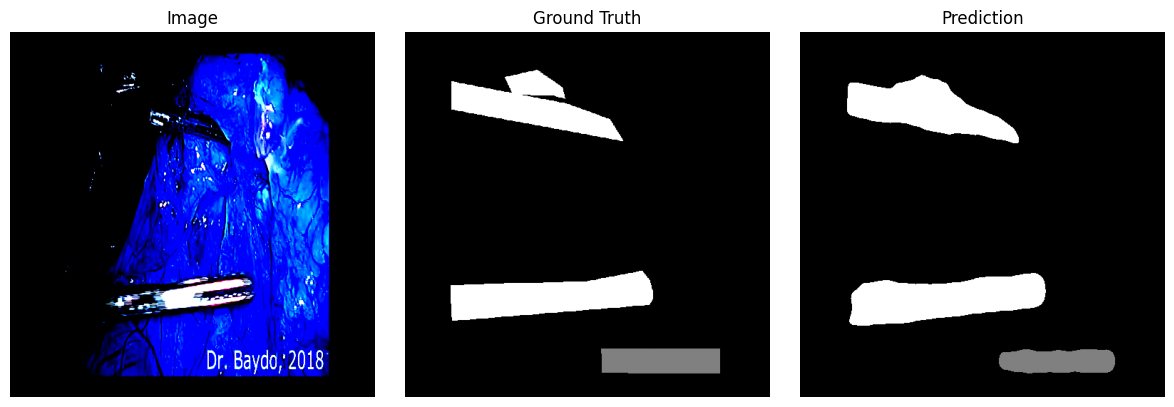

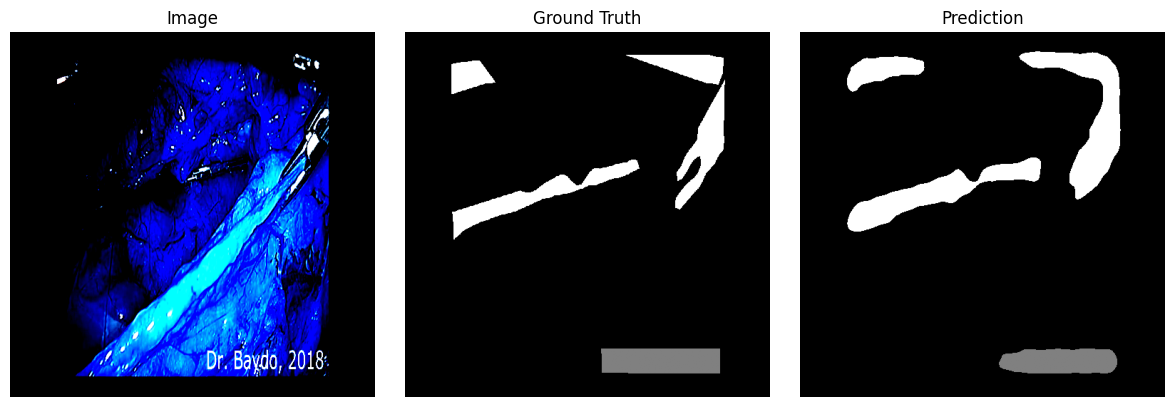


📅 Epoch 2/10
📊 Train Loss: 0.0658 | Val Loss: 0.0769
🎯 F1: 0.9220 | IoU: 0.9473 | Dice: 0.3243 | Precision: 0.8887 | Recall: 0.9710


✅ Best model saved


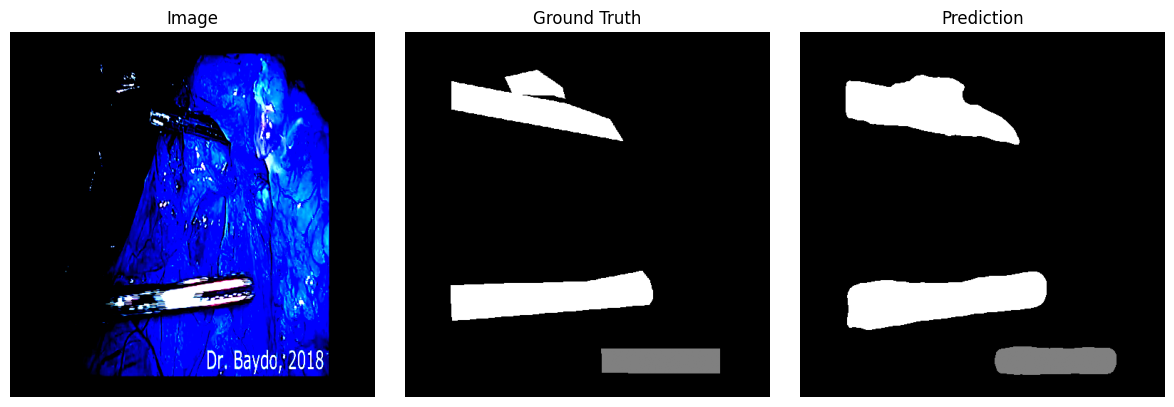

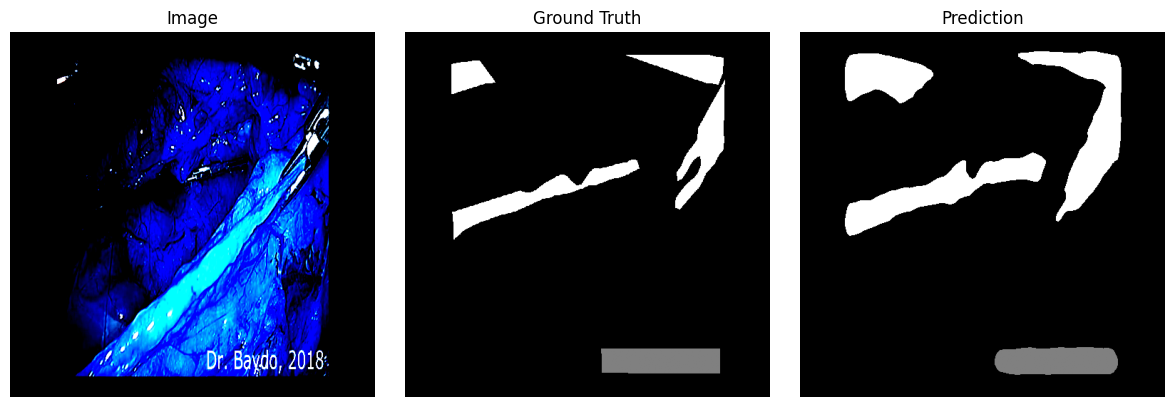

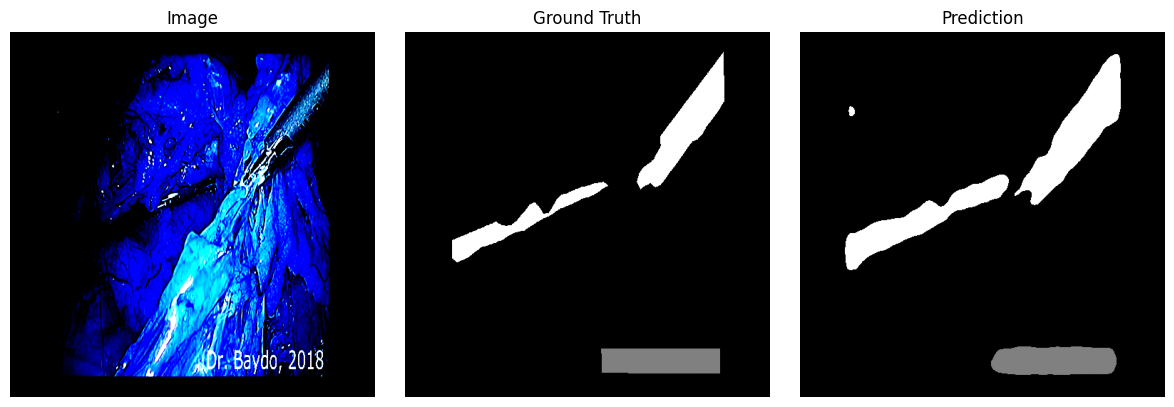


📅 Epoch 3/10
📊 Train Loss: 0.0524 | Val Loss: 0.0525
🎯 F1: 0.9358 | IoU: 0.9559 | Dice: 0.3258 | Precision: 0.9048 | Recall: 0.9796


✅ Best model saved


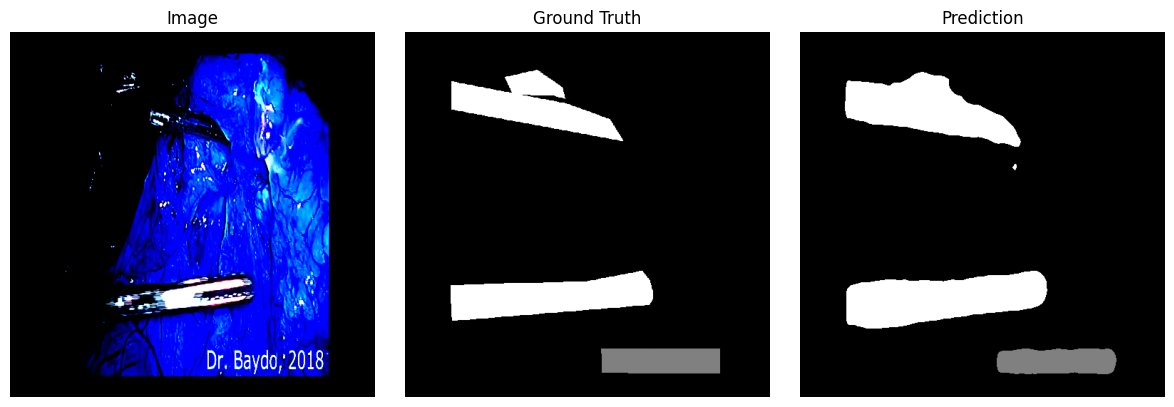

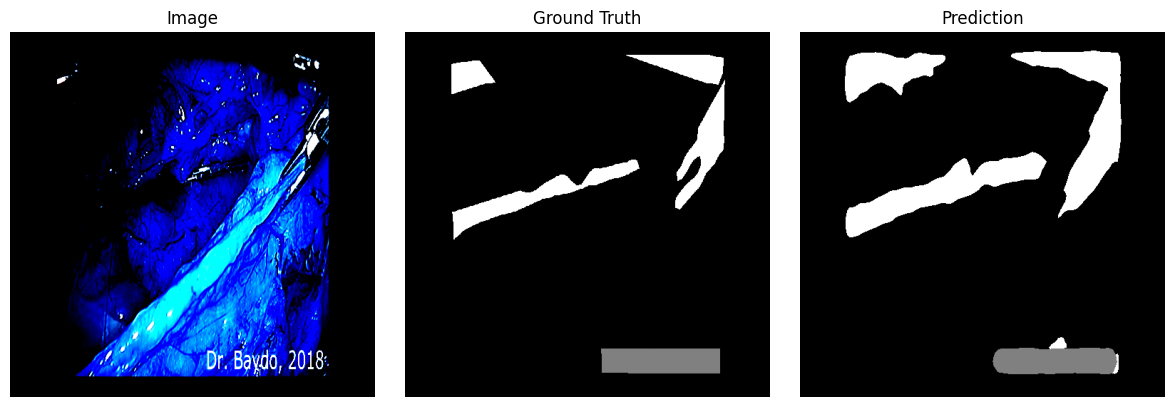

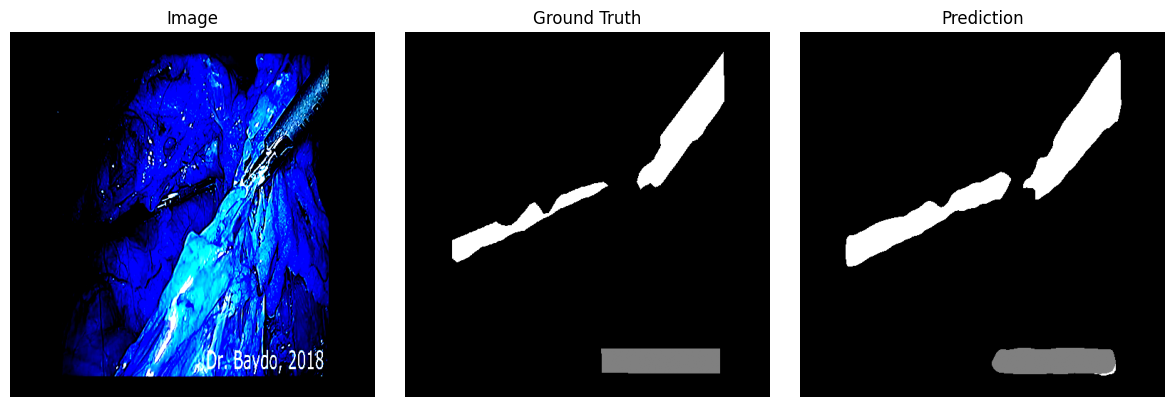


📅 Epoch 4/10


📊 Train Loss: 0.0519 | Val Loss: 0.0483
🎯 F1: 0.9320 | IoU: 0.9555 | Dice: 0.3257 | Precision: 0.8991 | Recall: 0.9804
⏳ Patience: 1/3


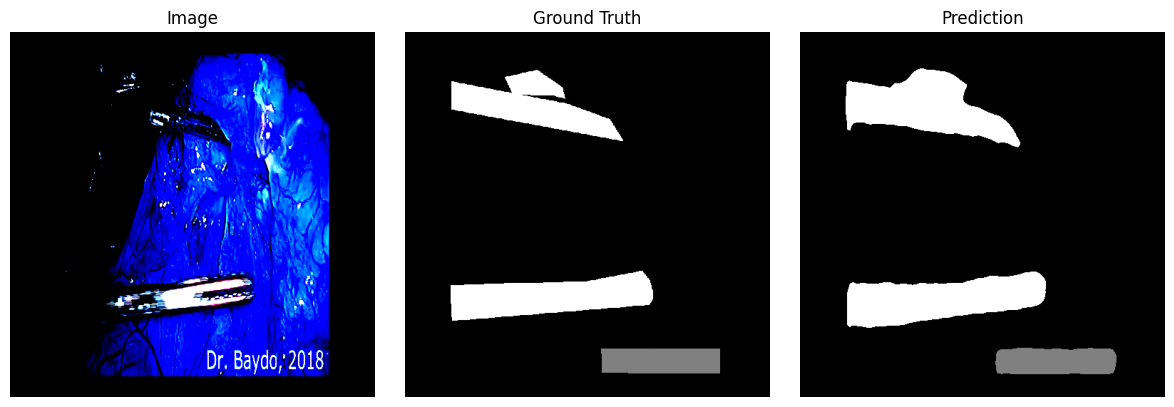

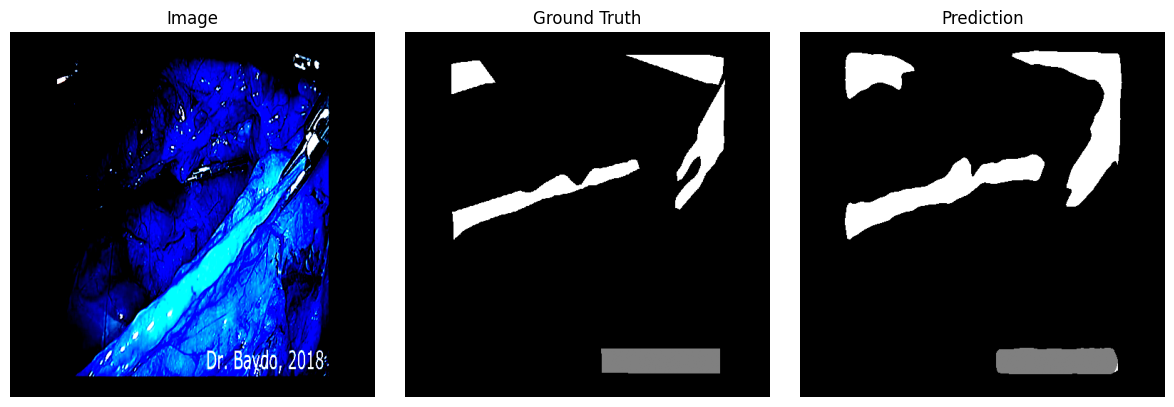

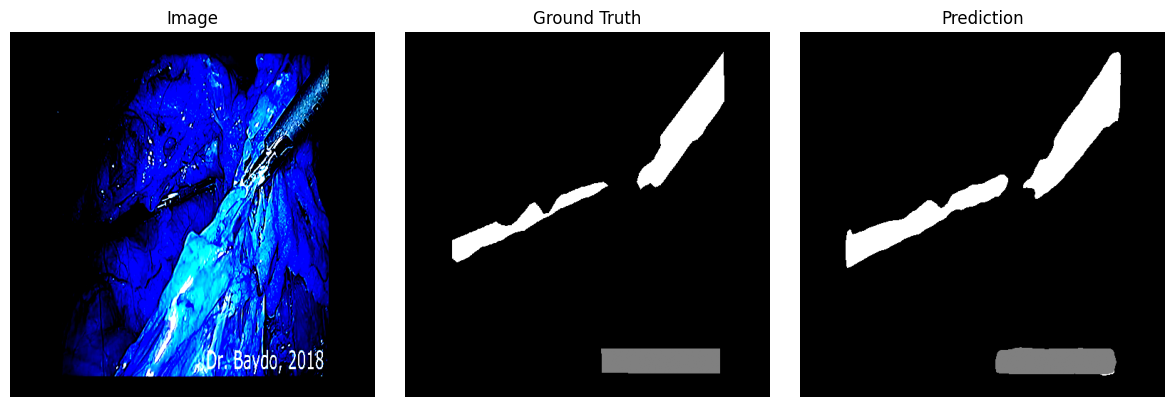


📅 Epoch 5/10
📊 Train Loss: 0.0429 | Val Loss: 0.0496
🎯 F1: 0.9498 | IoU: 0.9647 | Dice: 0.3273 | Precision: 0.9258 | Recall: 0.9803


✅ Best model saved


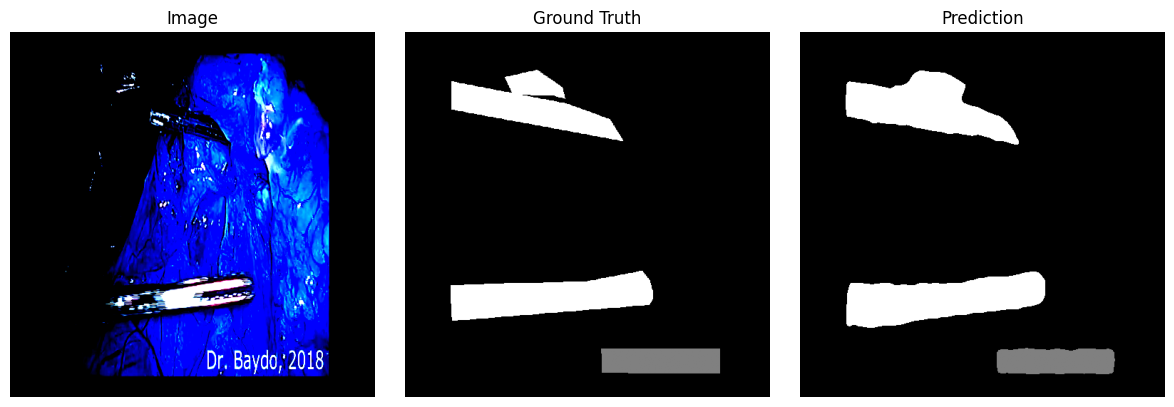

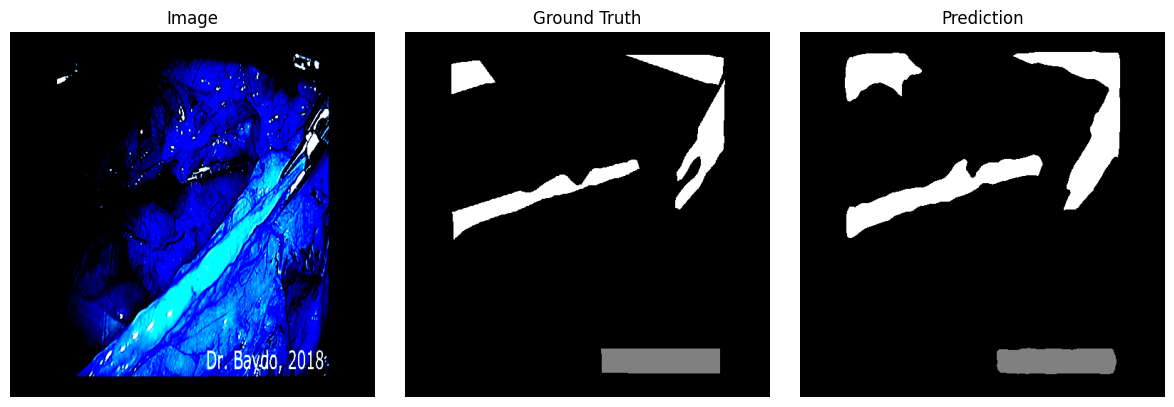

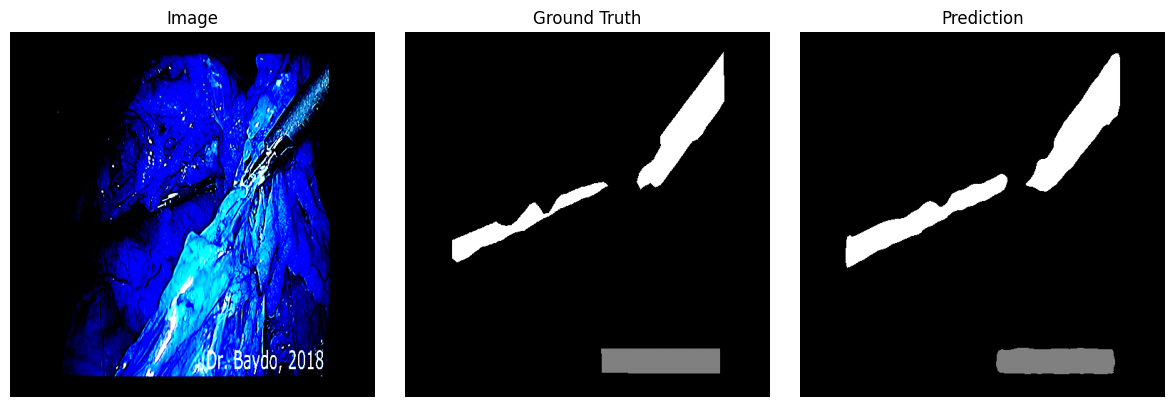


📅 Epoch 6/10


📊 Train Loss: 0.0433 | Val Loss: 0.0473
🎯 F1: 0.9461 | IoU: 0.9633 | Dice: 0.3271 | Precision: 0.9187 | Recall: 0.9823
⏳ Patience: 1/3


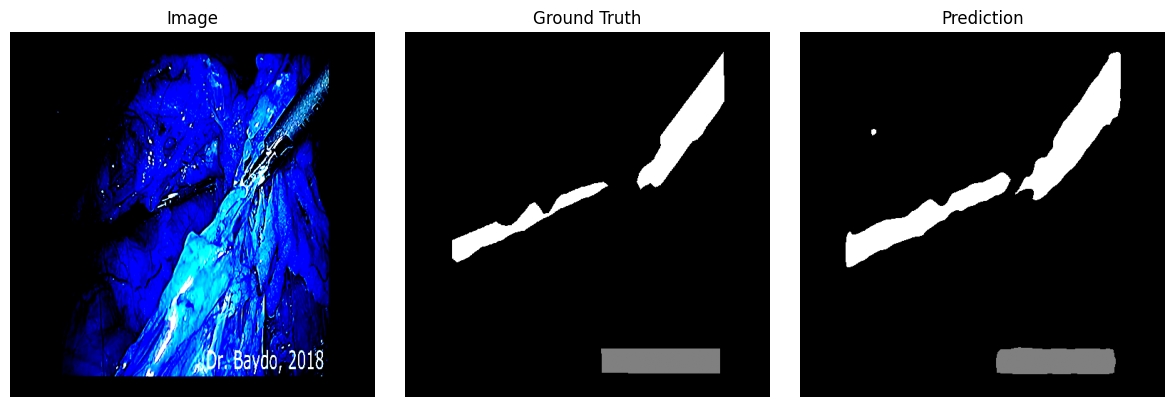


📅 Epoch 7/10


📊 Train Loss: 0.0363 | Val Loss: 0.0443
🎯 F1: 0.9495 | IoU: 0.9651 | Dice: 0.3274 | Precision: 0.9240 | Recall: 0.9826
⏳ Patience: 2/3


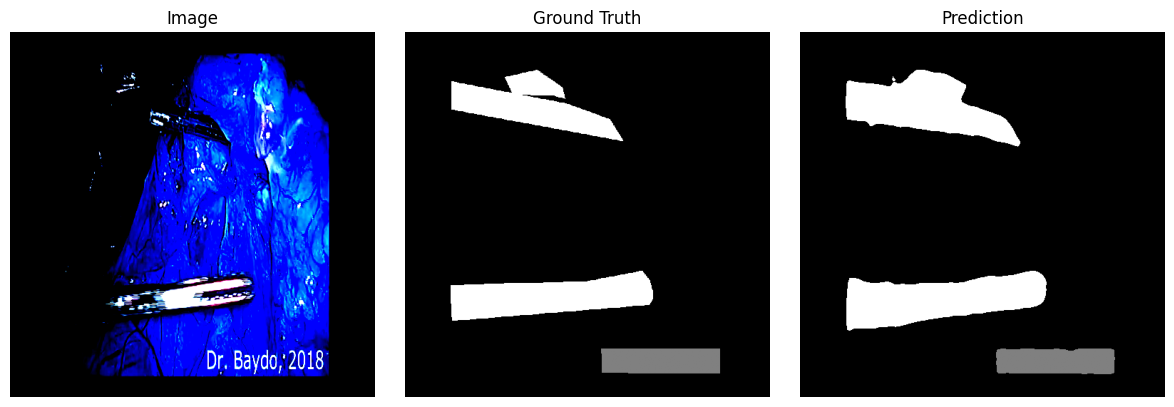

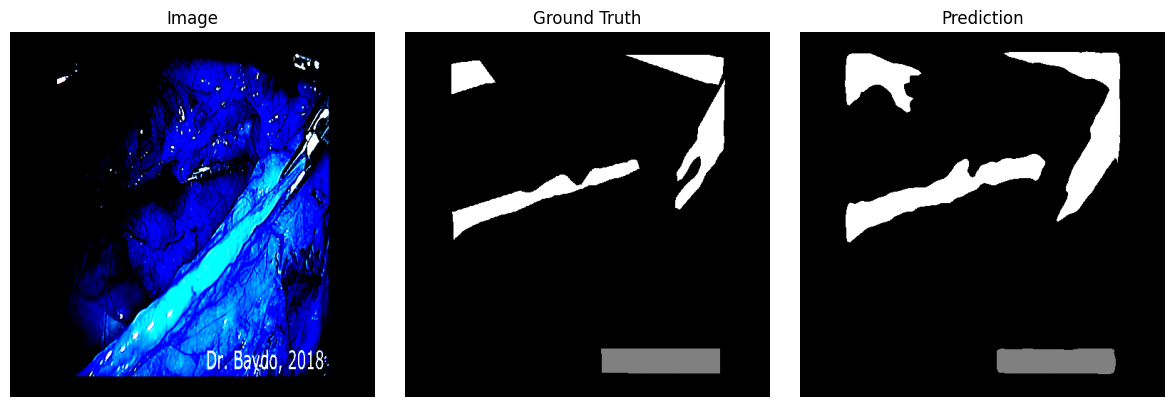

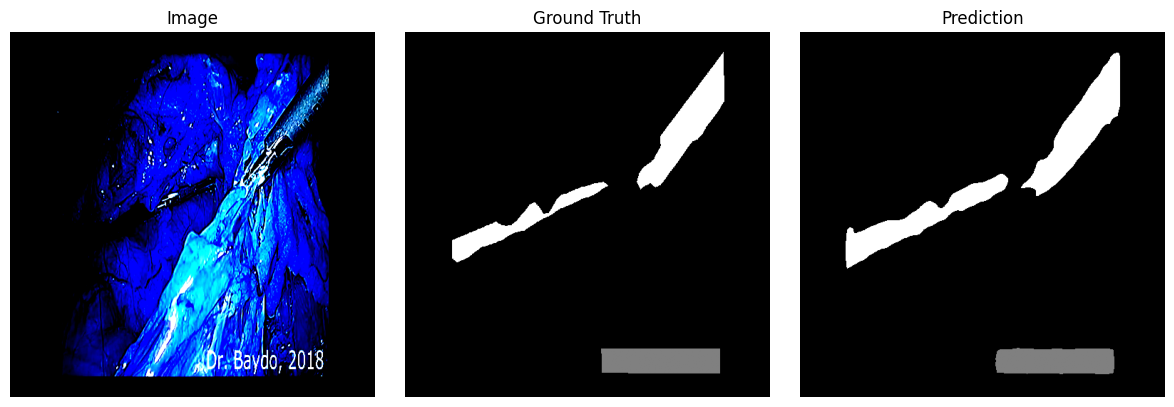


📅 Epoch 8/10
📊 Train Loss: 0.0331 | Val Loss: 0.0486
🎯 F1: 0.9497 | IoU: 0.9671 | Dice: 0.3278 | Precision: 0.9240 | Recall: 0.9828
⏳ Patience: 3/3
🛑 Early stopping triggered!


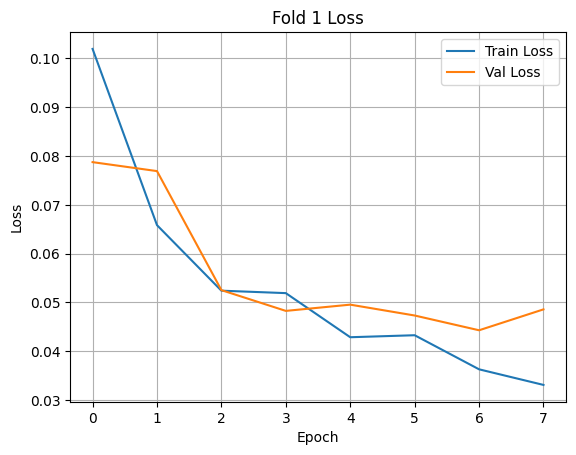


📦 Fold 2/5
✅ Saved class weights to /content/drive/MyDrive/surgical_dataset/class_weights.npy


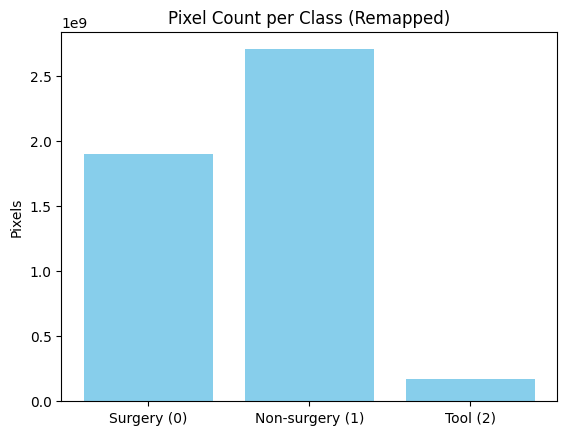


📅 Epoch 1/10
📊 Train Loss: 0.1018 | Val Loss: 0.0603
🎯 F1: 0.9299 | IoU: 0.9525 | Dice: 0.3252 | Precision: 0.8992 | Recall: 0.9737


✅ Best model saved


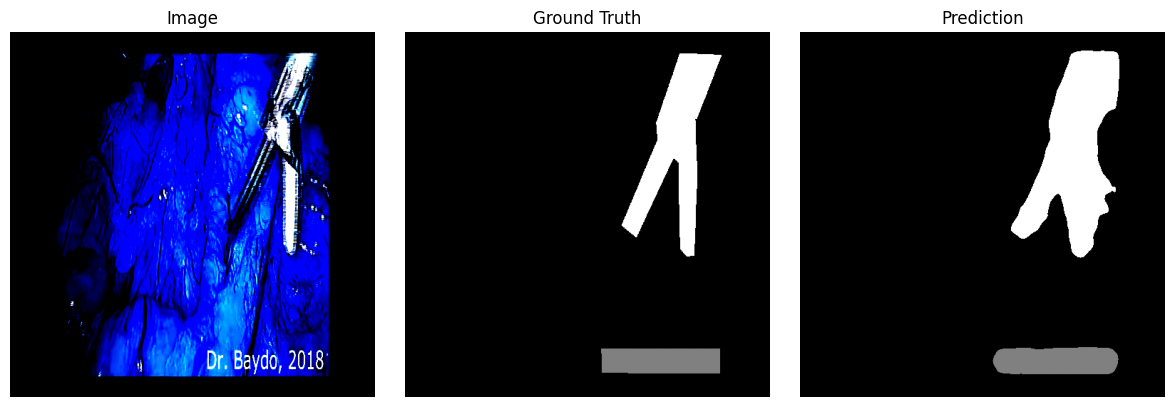


📅 Epoch 2/10
📊 Train Loss: 0.0650 | Val Loss: 0.0612
🎯 F1: 0.9438 | IoU: 0.9601 | Dice: 0.3265 | Precision: 0.9197 | Recall: 0.9745


✅ Best model saved


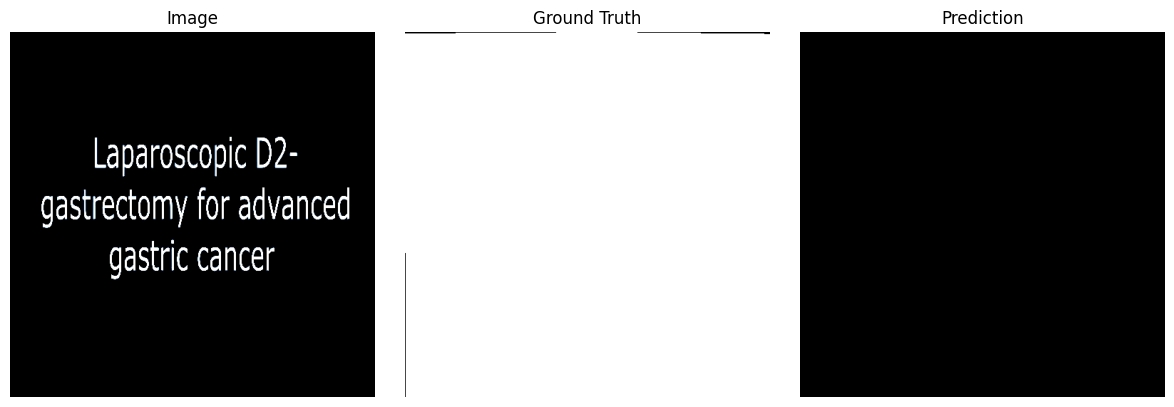

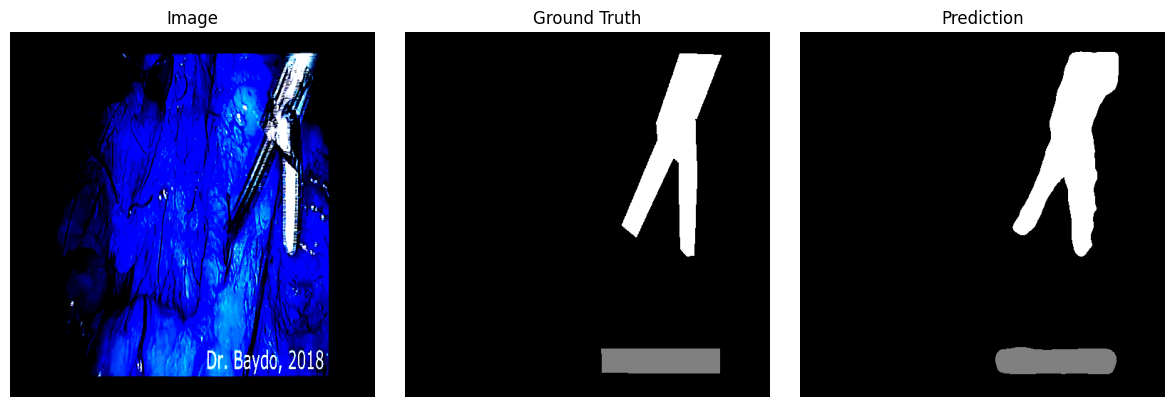


📅 Epoch 3/10


📊 Train Loss: 0.0557 | Val Loss: 0.0492
🎯 F1: 0.9395 | IoU: 0.9610 | Dice: 0.3267 | Precision: 0.9102 | Recall: 0.9797
⏳ Patience: 1/3


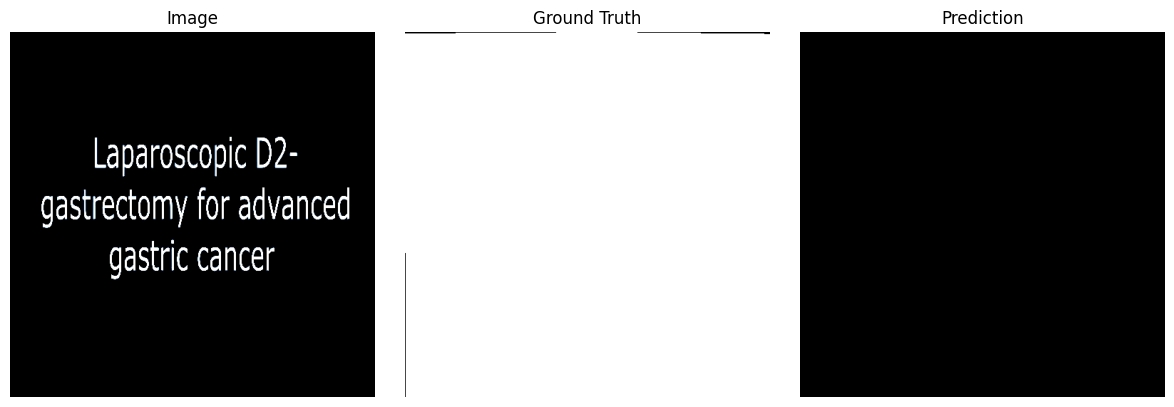

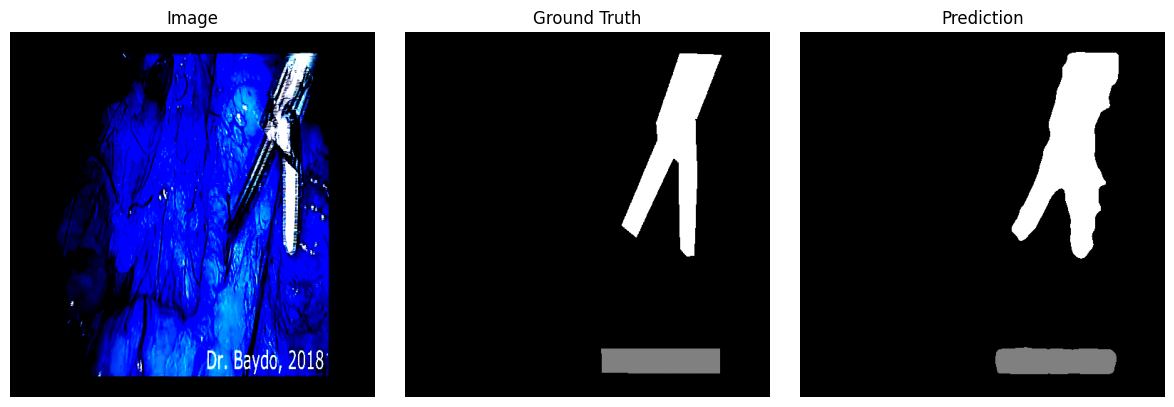


📅 Epoch 4/10


In [ ]:
# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics_df = pd.DataFrame(columns=["Fold", "Epoch", "Train Loss", "Val Loss", "F1", "Precision", "Recall", "IoU"])

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n📦 Fold {fold+1}/5")

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

     # Compute class weights on training subset
    class_weights = compute_class_weights(train_subset).to(device)

    # Augment train set, normalize val set
    train_dataset = TransformDataset(train_subset, A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]))
    val_dataset = TransformDataset(val_subset, A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]))

    # Create loaders with StratifiedBatchSampler
    train_labels = [labels[i] for i in train_idx]
    train_loader = DataLoader(train_dataset, batch_sampler=StratifiedBatchSampler(train_labels, batch_size), num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = DeepLabV3Plus(num_classes=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    # Trackers
    best_f1 = 0
    patience_counter = 0
    train_losses, val_losses = [], []
    best_model_path = f"best_deeplabv3plus_fold{fold+1}.pth"
    checkpoint_path = f"checkpoint_fold{fold+1}.pth"

    for epoch in range(num_epochs):
        print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, f1, prec, rec, val_iou, val_dice = evaluate(model, val_loader, loss_fn, device)
        print(f"📊 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"🎯 F1: {f1:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save metrics
        metrics_df.loc[len(metrics_df)] = {
            "Fold": fold+1,
            "Epoch": epoch+1,
            "Train Loss": train_loss,
            "Val Loss": val_loss,
            "F1": f1,
            "Precision": prec,
            "Recall": rec,
            "IoU": val_iou
        }

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print("✅ Best model saved")
        else:
            patience_counter += 1
            print(f"⏳ Patience: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

        # Show predictions
        with torch.no_grad():
            for images, masks in val_loader:
                preds = torch.argmax(model(images.to(device))["out"], dim=1)
                visualize_batch(images, masks, preds)
                break

    # Plot training/validation loss
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"Fold {fold+1} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(); plt.grid(True); plt.show()

# Part 6: Final Test Evaluation + Metrics CSV Export

In [1]:
# 🧪 Transform test set
test_dataset = TransformDataset(test_dataset, A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
]))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 🔍 Load best model for evaluation (choose best fold manually or average across folds)
model = DeepLabV3Plus(num_classes=3).to(device)
model.load_state_dict(torch.load("best_deeplabv3plus_fold2.pth"))  # Or best performing fold

# 🔎 Evaluate on test set
test_loss, test_f1, test_prec, test_rec, test_iou = evaluate(model, test_loader, loss_fn, device)
print(f"\n🧪 Final Test Evaluation:")
print(f"Loss: {test_loss:.4f} | IoU: {test_iou:.4f} | Precision: {test_prec:.4f} | Recall: {test_rec:.4f} | F1: {test_f1:.4f}")

NameError: name 'TransformDataset' is not defined

In [ ]:
# Generate predictions and ground truths
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        outputs = model(images.to(device))["out"]
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(masks.numpy().flatten())

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 29, 149])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Surgery", "Non-Surgery", "Tool"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [ ]:
metrics_df.to_csv("deeplabv3plus_metrics.csv", index=False)
print("📁 Metrics saved to: deeplabv3plus_metrics.csv")